In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import pickle
import cvxopt
from scipy.spatial.distance import pdist,squareform,cdist
from sklearn.svm import SVC
from sklearn import metrics
import time

training_file = "drive/MyDrive/part2_data/train_data.pickle" #str(sys.argv[1])
testing_file  = "drive/MyDrive/part2_data/test_data.pickle"  #str(sys.argv[2])

EPSILON = 1e-4
gamma = 0.001
C = 1.0
TOTAL_CLASSES = 5

In [ ]:
def readData(file_name):
    file = open(file_name,"rb")
    fileDict = pickle.load(file)
    
    X = []
    Y = []

    for idx in range(len(fileDict["data"])):
        X.append(fileDict["data"][idx].reshape(-1))
        Y.append(fileDict["labels"][idx])

    X = np.array(X)
    Y = np.array(Y)
    
    X = X/255
    
    X = X.astype('float64')
    Y = Y.astype('float64')
    
    return X,Y

X,Y = readData(training_file)
X_test,Y_test = readData(testing_file)

In [ ]:
def svm_cvxopt(X,Y,isLinear,C,gamma):
    
    start_time = time.time()

    if isLinear:
        tempProd0 = np.matmul(X,X.T)
        tempProd = np.matmul(Y,Y.T)*tempProd0
        P = cvxopt.matrix(tempProd)
    else:
        tempProd0 = gaussian_kernel(X,X)
        P = cvxopt.matrix(np.matmul(Y,Y.T)*tempProd0)
    
    tempG = np.identity(Y.shape[0])
    G = cvxopt.matrix(np.append(tempG,-1*tempG,axis = 0))
    
    Q = cvxopt.matrix(-1*np.ones((Y.shape[0],1)))
    
    A = cvxopt.matrix(Y.T)
    
    tempH = np.ones((Y.shape[0],1))
    H = cvxopt.matrix(np.append(C * tempH, 0 * tempH, axis=0))
    
    B = cvxopt.matrix(0.0)
    
    sol = cvxopt.solvers.qp(P, Q, G, H, A, B, options={'show_progress': False})
    
    tempX = np.array(sol['x'])
    alpha = np.reshape(tempX, (Y.shape[0],1))
    
    indices = []
    
    for idx in range(Y.shape[0]):
        if alpha[idx] > EPSILON:
            indices.append(idx)

    if isLinear:
      inner_product = np.sum(alpha*Y*tempProd0,0)
    else:
      inner_product = np.sum(alpha*Y*gaussian_kernel(X,X),0)

    M = -float("inf")
    M_index = -1
    m = float("inf")
    m_index = -1

    for idx in range(Y.shape[0]):
        val = -float("inf") if Y[idx]==1 else inner_product[idx]
        if M<val:
          M = val
          M_index = idx
        
        val = float("inf") if Y[idx]==-1 else inner_product[idx]
        if m>val:
          m = val
          m_index = idx
    
    b = -1*(inner_product[M_index]+inner_product[m_index])/2
    
    print("Total training time: "+str(time.time()-start_time))
    return alpha,indices,b

def LinearAccuracy(X,Y,W,b):
    pred = np.where((np.matmul(X,W)+b)>=0,1,-1)
    return (sum(pred==Y)[0]*100)/Y.shape[0]

def gaussian_kernel(x, y):
    return np.exp(-1*gamma * cdist(x, y, "sqeuclidean"))

def eval(x_test, y_test,X_train,Y_train,alpha,b,indices,gamma):
    y_hat = (np.sum(alpha * Y_train * gaussian_kernel(X_train, x_test),axis=0,keepdims=True).T + b)
    return np.sign(y_hat)

def GaussAccuracy(X_test,Y_test,X_train,Y_train,alpha,b,indices,gamma):
    final_pred = eval(X_test,Y_test,X_train[indices],Y_train[indices],alpha[indices],b,indices,gamma)

    return (sum(final_pred==Y_test)[0]*100)/Y_test.shape[0]

In [ ]:
def kC2_cvxopt(X,Y,C,gamma):
    classifier = {}

    for idx in range(TOTAL_CLASSES):
      for jdx in range(idx+1,TOTAL_CLASSES):

        indices = np.append(np.where(Y==idx)[0],np.where(Y==jdx)[0])
        Xij = X[indices]
        Yij = np.where(Y[indices]==jdx,1,-1)

        Xij = Xij.astype('float64')
        Yij = Yij.astype('float64')
        
        classifier[idx,jdx] = svm_cvxopt(Xij,Yij,False,C,gamma)
        print(str(idx)+","+str(jdx)+": Model trained")
    
    return classifier

In [ ]:
classifier = kC2_cvxopt(X,Y,C,gamma)

Total training time: 161.1830370426178
0,1: Model trained
Total training time: 167.7929708957672
0,2: Model trained
Total training time: 163.53690385818481
0,3: Model trained
Total training time: 159.71769952774048
0,4: Model trained
Total training time: 143.9530894756317
1,2: Model trained
Total training time: 144.38513350486755
1,3: Model trained
Total training time: 149.95694017410278
1,4: Model trained
Total training time: 138.4237790107727
2,3: Model trained
Total training time: 144.09424567222595
2,4: Model trained
Total training time: 137.6224865913391
3,4: Model trained


In [ ]:
def kC2_accuracy(X_test,Y_test,X_train,Y_train,classifier):

  shape = (Y_test.shape[0],TOTAL_CLASSES)
  votes = np.zeros(shape)

  for idx in range(TOTAL_CLASSES):
    for jdx in range(idx+1,TOTAL_CLASSES):
      
      indices = np.append(np.where(Y_train==idx)[0],np.where(Y_train==jdx)[0])
      Xij = X_train[indices]
      Yij = np.where(Y_train[indices]==jdx,1,-1)

      Xij = Xij.astype('float64')
      Yij = Yij.astype('float64')

      ALPHA = classifier[idx,jdx][0]
      INDICES = classifier[idx,jdx][1]
      B = classifier[idx,jdx][2]

      this_pred = eval(X_test,Y_test,Xij[INDICES],Yij[INDICES],ALPHA[INDICES],B,INDICES,gamma)

      for kdx in range(Y_test.shape[0]):
        if this_pred[kdx]==1:
          votes[kdx][jdx] += 1
        else:
          votes[kdx][idx] += 1
      
      print(str(idx)+","+str(jdx)+": prediction done")

  pred = np.reshape(np.argmax(votes,1),(Y_test.shape[0],1))
  acc = (sum(pred==Y_test)[0]*100)/Y_test.shape[0]
  print("Accuracy is : "+str(acc))
  print(metrics.confusion_matrix(Y_test,pred))

  return pred

In [ ]:
#print("For training dataset: ")
#kc2_train_pred = kC2_accuracy(X,Y,classifier)
print("For testing dataset: ")
kc2_test_pred = kC2_accuracy(X_test,Y_test,X,Y,classifier)

For testing dataset: 
0,1: prediction done
0,2: prediction done
0,3: prediction done
0,4: prediction done
1,2: prediction done
1,3: prediction done
1,4: prediction done
2,3: prediction done
2,4: prediction done
3,4: prediction done
Accuracy is : 56.86
[[739  47 105  62  47]
 [139 567  90 175  29]
 [145  24 459 207 165]
 [ 97  39 134 661  69]
 [ 83  20 288 192 417]]


In [ ]:
def sklearn_svm(X,Y,X_test,Y_test,isLinear,C,gamma):

    if isLinear:
        print("Training the linear classifer")
        clf = SVC(kernel='linear', C=C)
    else:
        print("Training the gaussian classifer")
        clf = SVC(kernel='rbf', gamma=gamma, C=C)
    
    start_time = time.time()
    clf.fit(X,Y)
    print("Total training time: "+str(time.time()-start_time))
    
    pred = clf.predict(X)

    print("Number of support vectors used : "+str(np.sum(clf.n_support_)))
    print("Training accuracy: "+str(metrics.accuracy_score(pred,Y)))

    test_pred = clf.predict(X_test)
    print("Testing accuracy: "+str(metrics.accuracy_score(test_pred,Y_test)))

    if(isLinear and False):
      print("The values of w and b in case of linear are: ")
      print(clf.coef_[0])
      print(clf.intercept_[0])
    
    #print("The confusion matrix on training data is : ")
    #print(metrics.confusion_matrix(Y,pred))

    print("The confusion matrix on testing data is : ")
    print(metrics.confusion_matrix(Y_test,test_pred))

    return test_pred

In [ ]:
test_pred = sklearn_svm(X,Y,X_test,Y_test,False,C,gamma)

Training the gaussian classifer


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total training time: 216.54402422904968
Number of support vectors used : 8450
Training accuracy: 0.6228
Testing accuracy: 0.593
The confusion matrix on training data is : 
[[1444  185  147  130   94]
 [ 170 1525   63  156   86]
 [ 305  110  898  240  447]
 [ 141  174  208 1225  252]
 [ 193   87  359  225 1136]]
The confusion matrix on testing data is : 
[[729  83  78  61  49]
 [100 731  42  92  35]
 [145  61 409 133 252]
 [ 82  97 123 572 126]
 [ 98  48 212 118 524]]


In [ ]:
def missclassified(test_pred,Y_test,X_test):
  count = 5
  for idx in range(len(test_pred)):
    if test_pred[idx]!=Y_test[idx]:

      img = X_test[idx].reshape((32,32,3))
      plt.imshow(img, interpolation='none')
      plt.savefig("3c_img_"+str(idx))
      plt.show()
      count -= 1

      if(count==0): break
  pass

In [ ]:
from sklearn.utils import shuffle
X,Y = shuffle(X,Y)
X_test,Y_test = shuffle(X,Y)

from sklearn.model_selection import KFold

C_List = [1e-5, 1e-3, 1, 5, 10]

In [ ]:
def cross_SVM(X,Y,X_test,Y_test,C_List,gamma,kfolds = 5):

    val_acc = []
    test_acc = []
    kf = KFold(n_splits = kfolds)

    for thisC in C_List:
      print("Currently testing for : "+str(thisC))
      model = SVC(kernel='rbf', gamma=gamma, C=thisC)

      maxAcc = 0
      maxTestAcc = 0
      sumAcc = 0
      count = 0

      for train_index,test_index in kf.split(X):

        print("Started split num : "+str(count))
        
        X_big,X_small = X[train_index],X[test_index]
        Y_big,Y_small = Y[train_index],Y[test_index]

        count += 1

        model.fit(X_big,Y_big)
        model_pred = model.predict(X_small)
        thisAcc = metrics.accuracy_score(Y_small,model_pred)

        if thisAcc>maxAcc:
          maxAcc = thisAcc

          test_pred = model.predict(X_test)
          maxTestAcc = metrics.accuracy_score(Y_test,test_pred)

        sumAcc += thisAcc
      
      val_acc.append(sumAcc/kfolds)
      test_acc.append(maxTestAcc)
    
    return val_acc,test_acc

In [ ]:
val_acc,test_acc = cross_SVM(X,Y,X_test,Y_test,C_List,gamma,5)

Currently testing for : 1e-05
Started split num : 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Currently testing for : 0.001
Started split num : 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Currently testing for : 1
Started split num : 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Currently testing for : 5
Started split num : 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Currently testing for : 10
Started split num : 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started split num : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


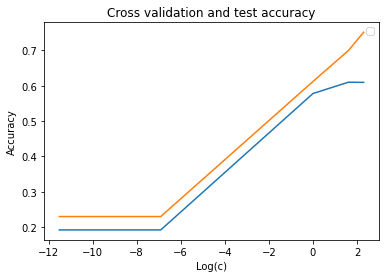

In [ ]:
c_vals_log = []

for thisC in C_List:
  c_vals_log.append(math.log(thisC))

plt.plot(c_vals_log, val_acc)
plt.plot(c_vals_log, test_acc)
plt.title("Cross validation and test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Log(c)")
plt.legend()
plt.savefig("3d.png")

In [ ]:
print(val_acc)
print(test_acc)